In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import tensorflow as tf

In [2]:
def load_data():
    # 读取数据
    x = np.load('train_data/train_data_2000.npy')
    y = np.load('train_data/label_2000.npy')
    num = len(Counter(y))
    print("类别数量为：", num)
    return x, y, num

In [3]:
def create_train_data(x, y, ratio=0.8):
    """
    x:数据
    y:类别
    ratio:生成训练集比率
    """
    # 打乱顺序
    # 读取data矩阵的第一维数（图片的个数）
    num_example = x.shape[0]
    # 产生一个num_example范围，步长为1的序列
    arr = np.arange(num_example)
    # 调用函数，打乱顺序
    np.random.seed(99)
    np.random.shuffle(arr)
    # 按照打乱的顺序，重新排序
    arr_data = x[arr]
    arr_label = y[arr]
    # 将数据集分为训练集80%、测试集20%
    s = int(num_example * ratio)
    x_train = arr_data[:s]
    y_train = arr_label[:s]
    x_val = arr_data[s:]
    y_val = arr_label[s:]
    print("训练集shape", x_train.shape)
    print("训练集类别：", Counter(y_train))
    print("测试集shape", x_val.shape)
    print("测试集类别：", Counter(y_val))
    return x_train, y_train, x_val, y_val

In [4]:
# 读取数据
data, label, label_count = load_data()
# 生成训练集测试集,70%用作训练，30%用作测试
train_data, train_label, val_data, val_label = create_train_data(data, label, 0.7)
print("*"*10)
print("训练集数量：",len(train_label))
print("测试集数量：",len(val_label))

类别数量为： 5
训练集shape (3150, 1000, 1)
训练集类别： Counter({0: 637, 1: 635, 3: 630, 4: 625, 2: 623})
测试集shape (1350, 1000, 1)
测试集类别： Counter({2: 277, 4: 275, 3: 270, 1: 265, 0: 263})
**********
训练集数量： 3150
测试集数量： 1350


## 机器学习

In [5]:
# 使用机器学习算法需要对多维数据进行降维
m_train = train_data.reshape(train_data.shape[0],train_data.shape[1]*train_data.shape[2])
m_val = val_data.reshape(val_data.shape[0],val_data.shape[1]*val_data.shape[2])

# 设置训练迭代次数
epoch = 10

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,accuracy_score,log_loss
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn import model_selection
from sklearn.preprocessing import  OneHotEncoder
from sklearn.tree import export_graphviz
import graphviz

### 决策树

In [7]:
# 决策树
tree = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 10, random_state = None)
# 模型准确率和损失值
sum = 0
acc_list = []
loss_list = []
train_acc_list = []
print("开始训练")
for i in range(1,epoch +1):

    # 模型训练
    tree.fit(m_train,train_label)

    # 测试集
    y_pred = np.asarray(tree.predict(m_val),dtype = 'int64')

    # 计算准确率
    acc = round(accuracy_score(val_label, y_pred),3)
    
    # 训练集
    y_pred = np.asarray(tree.predict(m_train),dtype = 'int64')
    # 计算准确率
    train_acc = round(accuracy_score(train_label, y_pred),3)
    
    # print('测试集准确率:', round(accuracy_score(val_label, y_pred),3))
    acc_list.append(acc)
    train_acc_list.append(train_acc)
    
    # 计算损失值
    # 使用one-hot编码计算损失值
    noe_hot = OneHotEncoder(sparse = False)

    y_pred_o = noe_hot.fit_transform(y_pred.reshape(1, -1))
    val_label_o = noe_hot.fit_transform(val_label.reshape(1, -1))
    
    print("完成第",i,"轮训练，测试集准确率：",acc)
    sum += acc
print("平均准确率：", sum / i)

开始训练
完成第 1 轮训练，测试集准确率： 0.45
完成第 2 轮训练，测试集准确率： 0.433
完成第 3 轮训练，测试集准确率： 0.444
完成第 4 轮训练，测试集准确率： 0.45
完成第 5 轮训练，测试集准确率： 0.437
完成第 6 轮训练，测试集准确率： 0.444
完成第 7 轮训练，测试集准确率： 0.439
完成第 8 轮训练，测试集准确率： 0.44
完成第 9 轮训练，测试集准确率： 0.436
完成第 10 轮训练，测试集准确率： 0.439
平均准确率： 0.4412


In [10]:
y_pred = np.asarray(tree.predict(m_val),dtype = 'int64')
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),3))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.439
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       0.28      0.33      0.30       263
           1       0.56      0.54      0.55       265
           2       0.61      0.58      0.59       277
           3       0.44      0.40      0.42       270
           4       0.34      0.33      0.34       275

    accuracy                           0.44      1350
   macro avg       0.45      0.44      0.44      1350
weighted avg       0.45      0.44      0.44      1350



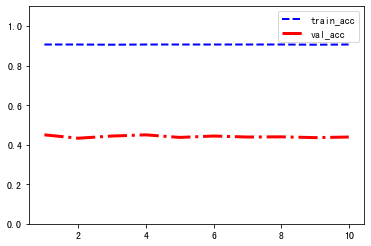

In [11]:
# 设置Y轴范围
plt.ylim(0,1.1)
# 训练准确率曲线
show_data1 = train_acc_list
# 测试准确率曲线
show_data2 = acc_list
x_data = list(range(1,len(show_data1)+1))
ln1, = plt.plot(x_data,show_data1,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['train_acc','val_acc'])
plt.show()

In [12]:
export_graphviz(tree,out_file="./tree/tree.dot",impurity=False,filled=True)
with open("./tree/tree.dot") as f:
    dot_graph=f.read()
    graph=graphviz.Source(dot_graph)
display(graph)

### 随机森林

In [13]:
# 模型参数设置
'''
第一类：
n_estimators：学习器的个数，interger，默认100
bootstrap：是否有放回抽样，boolean，默认True
第二类：
max_features：节点分裂时参与判断的最大特征数，默认auto，即sqrt(n_features)
max_depth：树的最大深度，int或None，默认None，表示对最大深度没有限制
min_samples_split：最小样本划分的数目，
min_samples_leaf：叶子节点最少样本数
'''

rfc = RandomForestClassifier(n_estimators = 100,min_samples_split = 2,min_samples_leaf = 2,max_depth = 50)

# 模型准确率和损失值
sum = 0
acc_list = []
loss_list = []
train_acc_list = []
print("开始训练")
for i in range(1,epoch +1):

    # 模型训练
    rfc.fit(m_train,train_label)
    
    # 测试集
    y_pred = np.asarray(rfc.predict(m_val),dtype = 'int64')

    # 计算准确率
    acc = round(accuracy_score(val_label, y_pred),3)
    
    # 训练集
    y_pred = np.asarray(rfc.predict(m_train),dtype = 'int64')
    # 计算准确率
    train_acc = round(accuracy_score(train_label, y_pred),3)
    
    # print('测试集准确率:', round(accuracy_score(val_label, y_pred),3))
    acc_list.append(acc)
    train_acc_list.append(train_acc)
    
    # 计算损失值
    # 使用one-hot编码计算损失值
    noe_hot = OneHotEncoder(sparse = False)

    y_pred_o = noe_hot.fit_transform(y_pred.reshape(1, -1))
    val_label_o = noe_hot.fit_transform(val_label.reshape(1, -1))
    
    print("完成第",i,"轮训练，测试集准确率：",acc)
    sum += acc
print("平均准确率：", sum / i)

开始训练
完成第 1 轮训练，测试集准确率： 0.866
完成第 2 轮训练，测试集准确率： 0.866
完成第 3 轮训练，测试集准确率： 0.859
完成第 4 轮训练，测试集准确率： 0.867
完成第 5 轮训练，测试集准确率： 0.878
完成第 6 轮训练，测试集准确率： 0.859
完成第 7 轮训练，测试集准确率： 0.873
完成第 8 轮训练，测试集准确率： 0.853
完成第 9 轮训练，测试集准确率： 0.865
完成第 10 轮训练，测试集准确率： 0.867
平均准确率： 0.8653000000000001


In [14]:
y_pred = np.asarray(rfc.predict(m_val),dtype = 'int64')
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),3))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.867
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       0.69      0.74      0.72       263
           1       0.99      1.00      0.99       265
           2       0.98      1.00      0.99       277
           3       0.84      0.95      0.89       270
           4       0.85      0.65      0.73       275

    accuracy                           0.87      1350
   macro avg       0.87      0.87      0.86      1350
weighted avg       0.87      0.87      0.86      1350



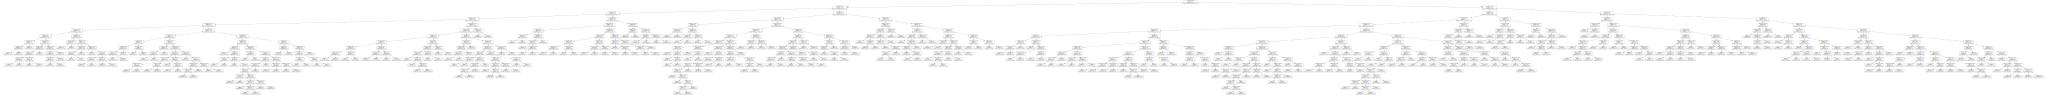

In [15]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
tree = rfc.estimators_[10]
export_graphviz(tree,out_file="./tree/tree_of_forest.dot")
with open("./tree/tree_of_forest.dot") as f:
    dot_graph=f.read()
    graph=graphviz.Source(dot_graph)
    
display(graph)

## 模型迭代准确率

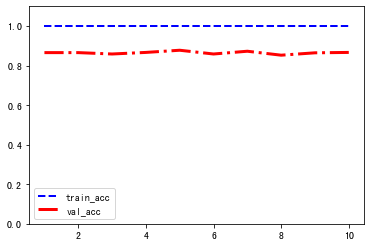

In [16]:
# 设置Y轴范围
plt.ylim(0,1.1)
# 训练准确率曲线
show_data1 = train_acc_list
# 测试准确率曲线
show_data2 = acc_list
x_data = list(range(1,len(show_data1)+1))
ln1, = plt.plot(x_data,show_data1,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['train_acc','val_acc'])
plt.show()

In [17]:
from joblib import dump, load
# 保存模型
dump(rfc, 'models_save/rfc.joblib') 
# # 加载
# rfc = load('models_save/rfc.joblib')
# print(rfc)

['models_save/rfc.joblib']

# CNN

In [18]:
from tensorflow import keras
from tensorflow.keras import layers, models
# 查看GPU是否可用
print(tf.config.list_physical_devices('GPU'))

[]


In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3412935443297669556
xla_global_id: -1
]


In [20]:
def cnn_create():
    loss = 'sparse_categorical_crossentropy'
    metrics = ['acc']
    inputs = keras.Input(shape=(1000, 1))
    x = layers.Conv1D(64, 3, activation='relu')(inputs)
    x = layers.MaxPooling1D(16)(x)
    # 全局平均池化GAP层
    x = layers.GlobalAveragePooling1D()(x)
    # 几个密集分类层
    x = layers.Dense(32, activation='relu')(x)
    # 退出层
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(label_count, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(0.001),
                  loss=loss,
                  metrics=metrics)
    print("实例化模型成功，参数如下：")
    print(model.summary())
    return model

In [21]:
# 实例化模型
cnn_model = cnn_create()

# 设置模型log输出地址
log_dir = os.path.join("logs/CNN")
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

实例化模型成功，参数如下：
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 998, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 62, 64)           0         
 )                                                               
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)        

In [22]:
# 模型训练
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = cnn_model.fit(train_data, train_label,epochs=20, batch_size=32, validation_split=0.1,callbacks=[tensorboard_callback])

Epoch 1/20
89/89 [==============================] - 1s 9ms/step - loss: 1.6091 - acc: 0.2109 - val_loss: 1.6018 - val_acc: 0.1714
Epoch 2/20
89/89 [==============================] - 1s 9ms/step - loss: 1.5921 - acc: 0.2427 - val_loss: 1.5844 - val_acc: 0.3841
Epoch 3/20
89/89 [==============================] - 1s 9ms/step - loss: 1.5649 - acc: 0.3354 - val_loss: 1.5525 - val_acc: 0.3238
Epoch 4/20
89/89 [==============================] - 1s 10ms/step - loss: 1.5105 - acc: 0.3594 - val_loss: 1.4542 - val_acc: 0.4698
Epoch 5/20
89/89 [==============================] - 1s 8ms/step - loss: 1.4052 - acc: 0.4113 - val_loss: 1.3191 - val_acc: 0.4063
Epoch 6/20
89/89 [==============================] - 1s 9ms/step - loss: 1.2843 - acc: 0.4286 - val_loss: 1.1865 - val_acc: 0.3841
Epoch 7/20
89/89 [==============================] - 1s 10ms/step - loss: 1.1774 - acc: 0.4684 - val_loss: 1.0792 - val_acc: 0.6159
Epoch 8/20
89/89 [==============================] - 1s 8ms/step - loss: 1.1052 - acc: 0.

In [23]:
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,accuracy_score,log_loss
print("*****完成预处理，进行模型评估*****")
y_pred = cnn_model.predict(val_data)
y_pred = [np.argmax(x) for x in y_pred]

*****完成预处理，进行模型评估*****
43/43 [==============================] - 0s 3ms/step


In [24]:
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),6))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.84963
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       263
           1       1.00      0.99      0.99       265
           2       0.99      1.00      0.99       277
           3       0.62      0.96      0.75       270
           4       0.79      0.37      0.51       275

    accuracy                           0.85      1350
   macro avg       0.87      0.85      0.84      1350
weighted avg       0.87      0.85      0.84      1350



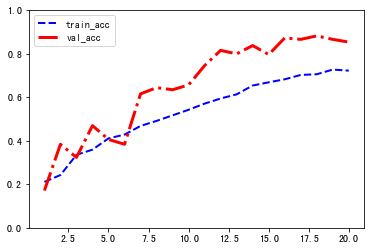

In [25]:
# 设置Y轴范围
plt.ylim(0,1)
# 训练准确率曲线
show_data1 = history.history['acc']
# 测试准确率曲线
show_data2 = history.history['val_acc']
x_data = list(range(1,len(show_data1)+1))
ln1, = plt.plot(x_data,show_data1,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['train_acc','val_acc'])
plt.show()